# Performance: numpy vs. event-based packages
*numpy vs. PyRX vs. Faust*

## Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import rx
from rx import operators as ops
import faust

np.set_printoptions(edgeitems=30, linewidth=10000)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 80
pd.options.display.max_colwidth = 100
plt.rcParams['font.family'] = 'monospace'
plt.style.use('seaborn')

## Moving Average

In [2]:
avg_window = 100
data = np.random.normal(0, 1, size=50000)
data

array([ 1.20858245, -0.57404419, -0.43654324, -0.62670887, -0.29275973, -0.72841826,  0.53845219, -0.40870148,  1.3109742 ,  0.18260668,  0.1123724 , -0.36697261, -0.86895797, -1.30289131, -1.00185488, -0.68308488, -0.92083117,  0.40363327, -1.8937615 ,  1.66433815, -1.16304624,  0.89438402,  0.02458225,  1.33034413, -0.16547048, -0.90143251,  0.62095984, -0.27438874,  0.97270481, -0.61194933, ..., -0.87160771, -0.39517824, -0.9108825 , -1.50667745, -0.31361101, -0.40606636,  1.07658872, -0.25795624, -0.05483391, -0.46178767, -1.29118717, -1.39887034, -0.87793568, -1.29443214,  0.22248749, -0.42668436, -0.30602039, -0.02556249, -0.04679575,  0.65136771,  1.54879497, -0.37068968,  0.54753401,  2.14910527, -2.47465955,  2.58821529, -0.05333567, -0.0222411 ,  0.91369428,  0.60477405])

### Numpy

In [3]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [4]:
%%time
metric = np.mean(rolling_window(data, avg_window), 1)
print(len(metric), metric[:5])

49901 [-0.09508324 -0.10380758 -0.08464035 -0.07655702 -0.0736542 ]
CPU times: user 4.23 ms, sys: 101 µs, total: 4.33 ms
Wall time: 3.23 ms


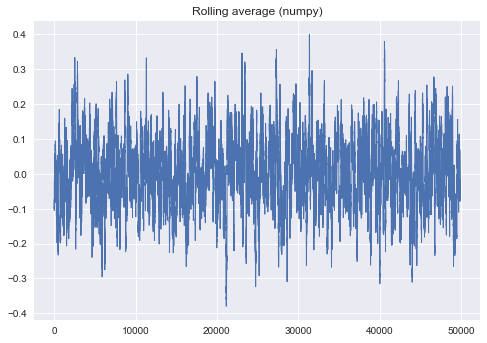

In [5]:
plt.plot(metric, lw=1)
plt.title('Rolling average (numpy)')
_=_

### PyRX

In [6]:
source = rx.from_list(data)

#### Method 1: buffer

In [7]:
%%time
metric = []
source.pipe(
    ops.buffer_with_count(count=avg_window, skip=1), 
    ops.map(lambda x: sum(x)/len(x)),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

50000 [-0.09508324319897037, -0.10380757697930143, -0.0846403467294968, -0.07655701765395147, -0.07365419953534642]
CPU times: user 9.14 s, sys: 0 ns, total: 9.14 s
Wall time: 9.14 s


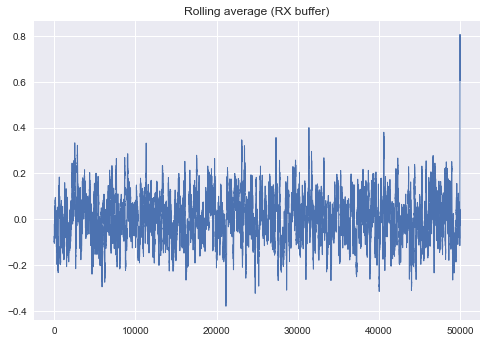

In [8]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX buffer)')
_=_

#### Method 2: scan

In [11]:
%%time
metric = []
source.pipe(
    ops.scan(lambda acc, x: (acc + [x])[-avg_window:], []),
#     ops.skip(1),
    ops.map(lambda x: sum(x)/len(x)),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

50000 [1.2085824545354398, 0.31726913267848617, 0.06599834036627338, -0.1071784630615552, -0.14429471594140045]
CPU times: user 249 ms, sys: 46 µs, total: 250 ms
Wall time: 249 ms


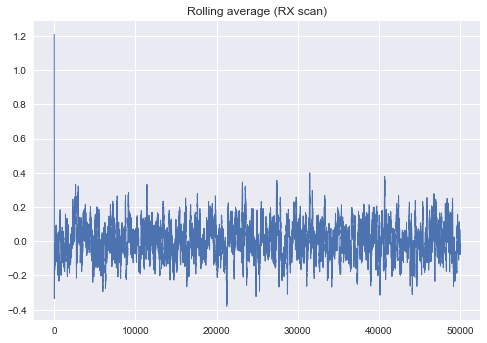

In [12]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX scan)')
_=_

#### Method 3: scan (optimized)

In [15]:
%%time
metric = []
source.pipe(
    ops.scan(lambda acc, x: acc + x, 0), 
    ops.scan(lambda acc, x: (acc + [x])[-avg_window-1:], []),
    ops.skip(1),
    ops.map(lambda x: (x[-1] - x[0])/(len(x)-1)),
).subscribe(
    on_next = lambda i: metric.append(i)
)
print(len(metric), metric[:5])

49999 [-0.5740441891784674, -0.5052937167183098, -0.5457654355938869, -0.4825140085606105, -0.5316948580041639]
CPU times: user 121 ms, sys: 20 µs, total: 121 ms
Wall time: 120 ms


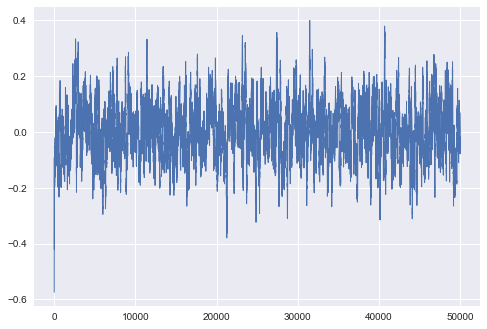

In [16]:
plt.plot(metric, lw=1)
plt.title('Rolling average (RX scan 2)')
_=_

## Faust

In [ ]:
# TODO